In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report
!pip install imbalanced-learn

In [ ]:
df = pd.read_csv('/content/data_final (3).csv')

In [ ]:
# 1. Ambil fitur dan label
X = df['stemming']
y = df['polarity']

# 2. Encoding label: 0 = Negatif, 1 = Positif
y = y.map({'Negatif': 0, 'Positif': 1})

# 3. Split data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Tokenisasi dan ubah teks menjadi sequence
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# 5. Padding sequence agar sama panjang
MAX_SEQUENCE_LENGTH = max(len(seq) for seq in X_train_seq)  # atau nilai tetap seperti 100
X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post')

# Vocab size untuk embedding layer
VOCAB_SIZE = len(tokenizer.word_index) + 1

In [ ]:
df['stemming'][97]

"['sukoharjo', 'semangat', 'jalan', 'program', 'mbg', 'dukung', 'presiden', 'prabowo', 'benarbenar', 'acung', 'jempol']"

In [ ]:
# Menampilkan hasil stemming pada indeks ke-97
stemming_text = df['stemming'][97]
print("Stemming pada indeks 97:", stemming_text)

# Mengubah teks ke dalam bentuk sequence
seq = tokenizer.texts_to_sequences([stemming_text])

# Melakukan padding pada sequence tersebut
padded_seq = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post')

# Menampilkan hasil paddingnya
print("Hasil padding pada indeks 97:", padded_seq)

Stemming pada indeks 97: ['sukoharjo', 'semangat', 'jalan', 'program', 'mbg', 'dukung', 'presiden', 'prabowo', 'benarbenar', 'acung', 'jempol']
Hasil padding pada indeks 97: [[341 134  18   3   2  17   6   9 315 821 613   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0]]


In [ ]:
import tensorflow as tf
from keras.layers import Layer
from keras import ops as kops

class AttentionLayer(Layer):
    def __init__(self, step_dim, bias=True, **kwargs):
        super().__init__(**kwargs)
        self.step_dim   = step_dim
        self.bias_flag  = bias
        self.features_dim = None

    def build(self, input_shape):
        self.features_dim = input_shape[-1]

        self.W = self.add_weight(
            shape=(self.features_dim,),
            initializer="glorot_uniform",
            name="W"
        )

        if self.bias_flag:
            self.b = self.add_weight(
                shape=(self.step_dim,),
                initializer="zeros",
                name="b"
            )

    def call(self, inputs, mask=None):
        eij = kops.reshape(
            kops.matmul(
                kops.reshape(inputs, (-1, self.features_dim)),
                kops.reshape(self.W, (self.features_dim, 1))
            ),
            (-1, self.step_dim)
        )

        if self.bias_flag:
            eij = eij + self.b

        eij = kops.tanh(eij)
        a   = kops.exp(eij)

        if mask is not None:
            a = a * kops.cast(mask, a.dtype)

        eps = tf.keras.backend.epsilon()  # ← FIXED
        a = a / (kops.sum(a, axis=1, keepdims=True) + eps)
        a = kops.expand_dims(a, axis=-1)
        context = kops.sum(inputs * a, axis=1)
        return context

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.features_dim)

## new code

In [ ]:
from keras import layers, optimizers, models
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import regularizers
from keras.layers import BatchNormalization
from keras import layers, optimizers, models, regularizers
from keras.layers import Bidirectional, BatchNormalization, Dropout, GRU
from keras.callbacks import EarlyStopping, ModelCheckpoint

EMBEDDING_DIM = 300
GRU_DIM       = 128 #sebelumnya 32

sequence_input     = layers.Input(shape=(MAX_SEQUENCE_LENGTH,))
embedded_sequences = layers.Embedding(VOCAB_SIZE, EMBEDDING_DIM, trainable=True)(sequence_input) # sebelumnya True
#bigru              = layers.Bidirectional(layers.GRU(GRU_DIM, return_sequences=True))(embedded_sequences)
bigru = Bidirectional(
    layers.GRU(GRU_DIM,
               return_sequences=True,
               dropout=0.3,           # dropout input-output
               recurrent_dropout=0.2  # dropout antar-state
    )
)(embedded_sequences)

att      = AttentionLayer(MAX_SEQUENCE_LENGTH)(bigru)
dense1   = layers.Dense(GRU_DIM*2, activation='relu', kernel_regularizer=regularizers.l2(0.01))(att)
 # tambahan baru untuk batch normalization
drop1    = layers.Dropout(0.3)(dense1) # sebelumnya 0.3
dense2   = layers.Dense(GRU_DIM, activation='relu')(drop1)
drop2    = layers.Dropout(0.3)(dense2)

outp     = layers.Dense(1, activation='sigmoid')(drop2)   # <- pakai drop2 biar dropout kepakai

model = models.Model(inputs=sequence_input, outputs=outp)
model.compile(
    loss='binary_crossentropy',
    optimizer=optimizers.Adam(learning_rate=0.001, clipnorm=1.0), #sebelumnya 0.001
    metrics=['accuracy']
)

# new code 2

In [ ]:
# Mengatur dimensi dan learning rate
EMBEDDING_DIM = 300
GRU_DIM       = 16  # Mengurangi dimensi GRU untuk mengurangi kompleksitas model
LEARNING_RATE = 0.001

# Learning rate scheduler
def lr_scheduler(epoch, lr):
    if epoch < 3:
        return lr
    else:
        return lr * 0.9  # Turunkan learning rate 10% setelah setiap epoch

# Menambah EarlyStopping dan ModelCheckpoint
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint("best_model.h5", monitor='val_loss', save_best_only=True, mode='min')

sequence_input     = layers.Input(shape=(MAX_SEQUENCE_LENGTH,))
embedded_sequences = layers.Embedding(VOCAB_SIZE, EMBEDDING_DIM, trainable=True)(sequence_input)

# Menambahkan regularisasi L2 pada GRU layer untuk menghindari overfitting
bigru = layers.Bidirectional(
    layers.GRU(GRU_DIM,
               return_sequences=True,
               kernel_regularizer=regularizers.l2(0.01),  # Regularisasi L2 pada GRU
               recurrent_regularizer=regularizers.l2(0.01),  # Regularisasi L2 pada recurrent GRU
               dropout=0.3  # Menambahkan dropout pada GRU layer
    )
)(embedded_sequences)

att = AttentionLayer(MAX_SEQUENCE_LENGTH)(bigru)

dense1 = layers.Dense(GRU_DIM * 2, activation='relu')(att)
drop1 = layers.Dropout(0.5)(dense1)

dense2 = layers.Dense(GRU_DIM, activation='relu')(drop1)
drop2 = layers.Dropout(0.5)(dense2)

outp = layers.Dense(1, activation='sigmoid')(drop2)

model = models.Model(inputs=sequence_input, outputs=outp)
model.compile(
    loss='binary_crossentropy',
    optimizer=optimizers.Adam(learning_rate=LEARNING_RATE),
    metrics=['accuracy']
)

In [ ]:
from keras import layers, optimizers, models

EMBEDDING_DIM = 300
GRU_DIM       = 32

sequence_input     = layers.Input(shape=(MAX_SEQUENCE_LENGTH,))
embedded_sequences = layers.Embedding(VOCAB_SIZE, EMBEDDING_DIM, trainable=True)(sequence_input)
bigru              = layers.Bidirectional(layers.GRU(GRU_DIM, return_sequences=True))(embedded_sequences)

att      = AttentionLayer(MAX_SEQUENCE_LENGTH)(bigru)
dense1   = layers.Dense(GRU_DIM*2, activation='relu')(att)
drop1    = layers.Dropout(0.5)(dense1)
dense2   = layers.Dense(GRU_DIM, activation='relu')(drop1)
drop2    = layers.Dropout(0.5)(dense2)

outp     = layers.Dense(1, activation='sigmoid')(drop2)   # <- pakai drop2 biar dropout kepakai

model = models.Model(inputs=sequence_input, outputs=outp)
model.compile(
    loss='binary_crossentropy',
    optimizer=optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)

In [ ]:
model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 49)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_7 (Embedding)         │ (None, 49, 300)        │     1,064,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_7 (Bidirectional) │ (None, 49, 64)         │        64,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_layer_7               │ (None, 64)             │           113 │
│ (AttentionLayer)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,135,214 (4.33 MB)

 Trainable params: 1,135,214 (4.33 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
import os

# Buat folder untuk menyimpan model terbaik
os.makedirs("best_model", exist_ok=True)

# Setup callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint("best_model/best_gru.keras",
                    monitor='val_accuracy',
                    save_best_only=True,
                    mode='max')
]

# Training model — gunakan data yang sudah diproses: X_train_pad, y_train
history = model.fit(
    X_train_pad, y_train,         # ← Ganti dari X_train ke X_train_pad
    batch_size=128,
    epochs=10,
    validation_split=0.1,         # ← Tambahkan validasi agar ModelCheckpoint bisa bekerja
    shuffle=True,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 11s 325ms/step - accuracy: 0.5482 - loss: 0.6913 - val_accuracy: 0.5893 - val_loss: 0.6848
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 197ms/step - accuracy: 0.5905 - loss: 0.6798 - val_accuracy: 0.5893 - val_loss: 0.6771
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 214ms/step - accuracy: 0.5723 - loss: 0.6790 - val_accuracy: 0.5893 - val_loss: 0.6610
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 386ms/step - accuracy: 0.5855 - loss: 0.6548 - val_accuracy: 0.6250 - val_loss: 0.6350
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 216ms/step - accuracy: 0.6871 - loss: 0.6213 - val_accuracy: 0.8214 - val_loss: 0.5704
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 241ms/step - accuracy: 0.7706 - loss: 0.5474 - val_accuracy: 0.8304 - val_loss: 0.4729
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 210ms/step - accuracy: 0.8413 - loss: 0.4032 - val_accuracy: 0.8482 - val_loss: 0.3976
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 210ms/step - accuracy: 0.9053 - loss: 0.2616 - val_accuracy: 0.8214 - val_loss

In [ ]:
ModelCheckpoint("best_model/best_gru.keras")

In [ ]:
from keras.models import load_model

# Pastikan AttentionLayer sudah didefinisikan dalam scope
model = load_model("best_model/best_gru.keras", custom_objects={"AttentionLayer": AttentionLayer})

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# Prediksi probabilitas
y_pred_probs = model.predict(X_test_pad)

# Konversi ke 0/1
y_pred = (y_pred_probs > 0.5).astype("int32")

# Evaluasi
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step
              precision    recall  f1-score   support

           0       0.87      0.87      0.87       142
           1       0.86      0.86      0.86       138

    accuracy                           0.86       280
   macro avg       0.86      0.86      0.86       280
weighted avg       0.86      0.86      0.86       280

[[123  19]
 [ 19 119]]


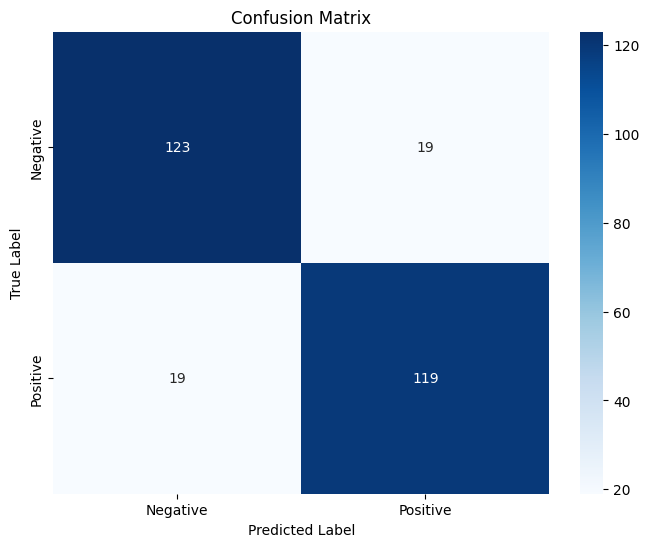

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
# Matriks kebingungan
cm = confusion_matrix(y_test, y_pred)

# Visualisasi matriks kebingungan
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

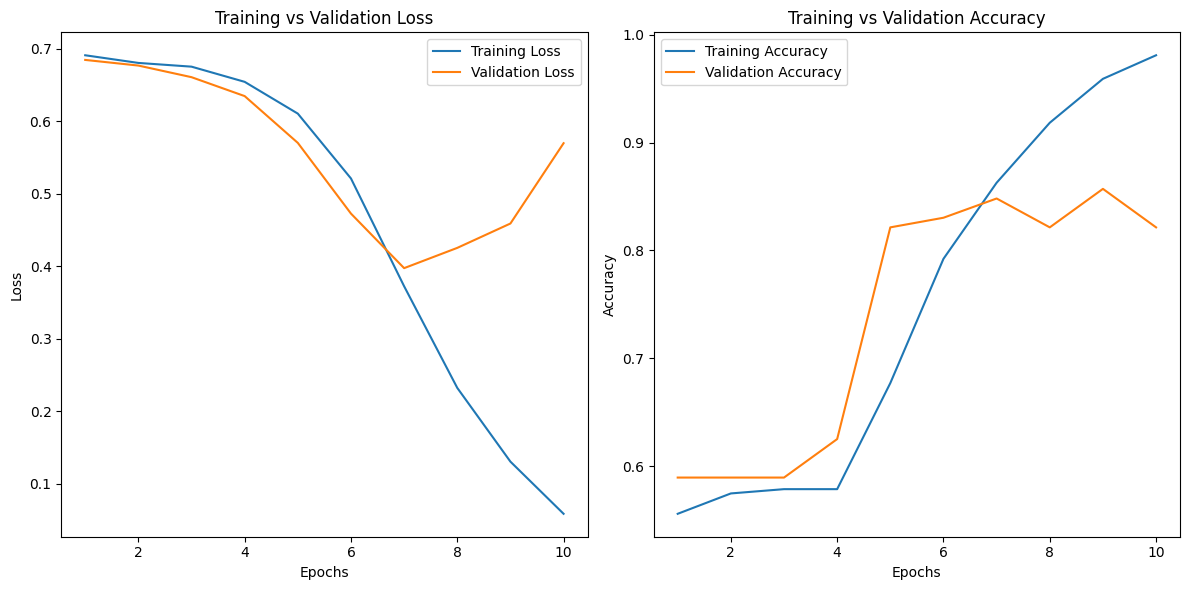

In [ ]:
import matplotlib.pyplot as plt

# Ambil data dari history
history_dict = history.history
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']
train_acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

# Grafik Loss
plt.figure(figsize=(12, 6))

# Subplot untuk loss
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Subplot untuk akurasi
plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_acc) + 1), train_acc, label='Training Accuracy')
plt.plot(range(1, len(val_acc) + 1), val_acc, label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Menampilkan grafik
plt.tight_layout()
plt.show()

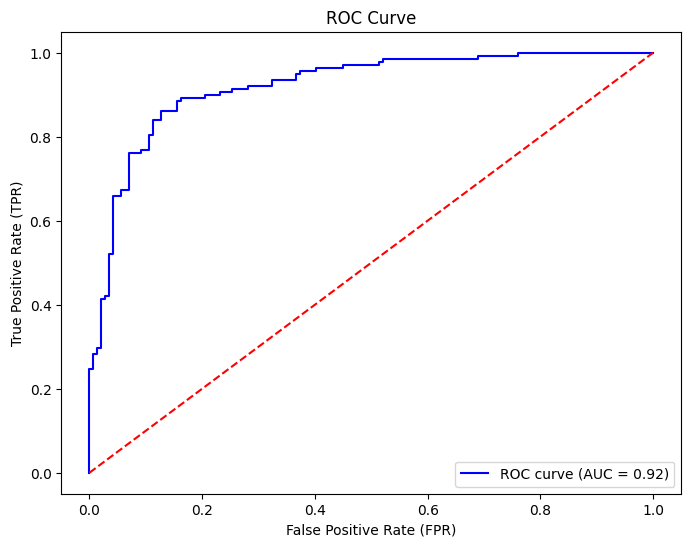

AUC Score: 0.9207491324760155


In [ ]:
from sklearn.metrics import roc_curve, auc

# Menghitung ROC curve dan AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)  # Menggunakan probabilitas untuk menghitung ROC
roc_auc = auc(fpr, tpr)  # Menghitung nilai AUC

# Menampilkan ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})", color='b')
plt.plot([0, 1], [0, 1], linestyle='--', color='r')  # Garis diagonal (random prediction)
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Menampilkan AUC Score
print("AUC Score:", roc_auc)

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
import os

# Buat folder untuk menyimpan model terbaik
os.makedirs("test_model", exist_ok=True)

# Setup callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint("best_model/best_gru.keras",
                    monitor='val_accuracy',
                    save_best_only=True,
                    mode='max')
]

# Training model — gunakan data yang sudah diproses: X_train_pad, y_train
history = model.fit(
    X_train_pad, y_train,         # ← Ganti dari X_train ke X_train_pad
    batch_size=32,
    epochs=10,
    validation_split=0.1,         # ← Tambahkan validasi agar ModelCheckpoint bisa bekerja
    shuffle=True,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 129ms/step - accuracy: 0.5315 - loss: 0.6928 - val_accuracy: 0.5893 - val_loss: 0.6850
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - accuracy: 0.5721 - loss: 0.6843 - val_accuracy: 0.5893 - val_loss: 0.6695
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - accuracy: 0.5984 - loss: 0.6545 - val_accuracy: 0.8125 - val_loss: 0.5527
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - accuracy: 0.7815 - loss: 0.4767 - val_accuracy: 0.7500 - val_loss: 0.5460
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 0.9196 - loss: 0.2396 - val_accuracy: 0.8125 - val_loss: 0.5727
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 0.9772 - loss: 0.0810 - val_accuracy: 0.8393 - val_loss: 0.6828
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - accuracy: 0.9813 - loss: 0.0529 - val_accuracy: 0.8304 - val_loss: 0.8248
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - accuracy: 0.9954 - loss: 0.0159 - val_accuracy: 0.8036 

In [ ]:
ModelCheckpoint("best_model/best_gru.keras")

In [ ]:
from keras.models import load_model

# Pastikan AttentionLayer sudah didefinisikan dalam scope
model = load_model("best_model/best_gru.keras", custom_objects={"AttentionLayer": AttentionLayer})

In [ ]:
# Prediksi probabilitas
y_pred_probs = model.predict(X_test_pad)

# Konversi ke 0/1
y_pred = (y_pred_probs > 0.5).astype("int32")

# Evaluasi
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step
              precision    recall  f1-score   support

           0       0.77      0.89      0.82       142
           1       0.86      0.72      0.79       138

    accuracy                           0.81       280
   macro avg       0.82      0.81      0.81       280
weighted avg       0.81      0.81      0.81       280

[[126  16]
 [ 38 100]]


Max validation accuracy: 0.8571428656578064


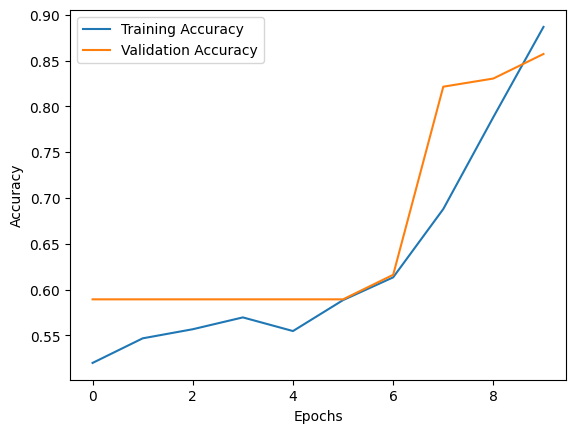

In [ ]:
import matplotlib.pyplot as plt
# Mencari akurasi tertinggi di validation
max_val_accuracy = max(history.history['val_accuracy'])
print(f'Max validation accuracy: {max_val_accuracy}')

# Plotting training dan validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# Evaluasi model dengan data test
y_pred_probs = model.predict(X_test_pad)
y_pred = (y_pred_probs > 0.5).astype("int32")

# Mencetak classification report dan confusion matrix
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
              precision    recall  f1-score   support

           0       0.77      0.89      0.82       142
           1       0.86      0.72      0.79       138

    accuracy                           0.81       280
   macro avg       0.82      0.81      0.81       280
weighted avg       0.81      0.81      0.81       280

[[126  16]
 [ 38 100]]


In [ ]:
from keras import layers, optimizers, models
from keras.regularizers import l2

EMBEDDING_DIM = 300
GRU_DIM       = 32

sequence_input     = layers.Input(shape=(MAX_SEQUENCE_LENGTH,))
embedded_sequences = layers.Embedding(VOCAB_SIZE, EMBEDDING_DIM, trainable=True)(sequence_input)

# Gunakan L2 Regularization pada GRU
bigru = layers.Bidirectional(
    layers.GRU(GRU_DIM, return_sequences=True, kernel_regularizer=l2(0.001))
)(embedded_sequences)

# Menambahkan Attention Layer (pastikan Anda sudah mendefinisikan AttentionLayer dengan benar)
att = AttentionLayer(MAX_SEQUENCE_LENGTH)(bigru)

# Menambahkan Regularization pada Dense Layer
dense1 = layers.Dense(GRU_DIM*2, activation='relu', kernel_regularizer=l2(0.001))(att)
drop1  = layers.Dropout(0.5)(dense1)

dense2 = layers.Dense(GRU_DIM, activation='relu', kernel_regularizer=l2(0.001))(drop1)
drop2  = layers.Dropout(0.5)(dense2)

outp = layers.Dense(1, activation='sigmoid')(drop2)

model = models.Model(inputs=sequence_input, outputs=outp)
model.compile(
    loss='binary_crossentropy',
    optimizer=optimizers.Adam(learning_rate=0.0005),  # Kurangi learning rate
    metrics=['accuracy']
)

from keras.callbacks import EarlyStopping, ModelCheckpoint
import os

# Buat folder untuk menyimpan model terbaik
os.makedirs("best_model", exist_ok=True)

# Setup callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),  # Kurangi patience
    ModelCheckpoint("best_model/best_gru.keras",
                    monitor='val_accuracy',
                    save_best_only=True,
                    mode='max')
]

# Training model — gunakan data yang sudah diproses: X_train_pad, y_train
history = model.fit(
    X_train_pad, y_train,
    batch_size=128,
    epochs=10,
    validation_split=0.1,
    shuffle=True,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 25s 766ms/step - accuracy: 0.4934 - loss: 1.0849 - val_accuracy: 0.5893 - val_loss: 1.0597
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 500ms/step - accuracy: 0.5271 - loss: 1.0543 - val_accuracy: 0.5893 - val_loss: 1.0295
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 247ms/step - accuracy: 0.5315 - loss: 1.0255 - val_accuracy: 0.5893 - val_loss: 1.0015
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 185ms/step - accuracy: 0.5754 - loss: 0.9939 - val_accuracy: 0.5893 - val_loss: 0.9751
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step - accuracy: 0.5623 - loss: 0.9709 - val_accuracy: 0.5893 - val_loss: 0.9503
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 181ms/step - accuracy: 0.5892 - loss: 0.9415 - val_accuracy: 0.5893 - val_loss: 0.9274
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 181ms/step - accuracy: 0.5841 - loss: 0.9242 - val_accuracy: 0.5893 - val_loss: 0.9059
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 185ms/step - accuracy: 0.5594 - loss: 0.9076 - val_accuracy: 0.5893 - val_loss

## Batch 16

In [ ]:
from keras import layers, optimizers, models
from keras.regularizers import l2

EMBEDDING_DIM = 300
GRU_DIM       = 32

sequence_input     = layers.Input(shape=(MAX_SEQUENCE_LENGTH,))
embedded_sequences = layers.Embedding(VOCAB_SIZE, EMBEDDING_DIM, trainable=True)(sequence_input)

# Gunakan L2 Regularization pada GRU
bigru = layers.Bidirectional(
    layers.GRU(GRU_DIM, return_sequences=True, kernel_regularizer=l2(0.001))
)(embedded_sequences)

# Menambahkan Attention Layer (pastikan Anda sudah mendefinisikan AttentionLayer dengan benar)
att = AttentionLayer(MAX_SEQUENCE_LENGTH)(bigru)

# Menambahkan Regularization pada Dense Layer
dense1 = layers.Dense(GRU_DIM*2, activation='relu', kernel_regularizer=l2(0.001))(att)
drop1  = layers.Dropout(0.4)(dense1)

dense2 = layers.Dense(GRU_DIM, activation='relu', kernel_regularizer=l2(0.001))(drop1)
drop2  = layers.Dropout(0.4)(dense2)

outp = layers.Dense(1, activation='sigmoid')(drop2)

model = models.Model(inputs=sequence_input, outputs=outp)
model.compile(
    loss='binary_crossentropy',
    optimizer=optimizers.Adam(learning_rate=0.0001),  # Kurangi learning rate
    metrics=['accuracy']
)

from keras.callbacks import EarlyStopping, ModelCheckpoint
import os

# Buat folder untuk menyimpan model terbaik
os.makedirs("best_model", exist_ok=True)

# Setup callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),  # Kurangi patience
    ModelCheckpoint("best_model/best_gru.keras",
                    monitor='val_accuracy',
                    save_best_only=True,
                    mode='max')
]

# Training model — gunakan data yang sudah diproses: X_train_pad, y_train
history = model.fit(
    X_train_pad, y_train,
    batch_size=64,
    epochs=15,
    validation_split=0.1,
    shuffle=True,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 101ms/step - accuracy: 0.5536 - loss: 1.0779 - val_accuracy: 0.5893 - val_loss: 1.0460
Epoch 2/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - accuracy: 0.5525 - loss: 1.0380 - val_accuracy: 0.5893 - val_loss: 1.0079
Epoch 3/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - accuracy: 0.5726 - loss: 0.9967 - val_accuracy: 0.5893 - val_loss: 0.9744
Epoch 4/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 82ms/step - accuracy: 0.5875 - loss: 0.9609 - val_accuracy: 0.5893 - val_loss: 0.9446
Epoch 5/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - accuracy: 0.5797 - loss: 0.9345 - val_accuracy: 0.5893 - val_loss: 0.9168
Epoch 6/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 100ms/step - accuracy: 0.5949 - loss: 0.9085 - val_accuracy: 0.5893 - val_loss: 0.8916
Epoch 7/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 69ms/step - accuracy: 0.5786 - loss: 0.8864 - val_accuracy: 0.5893 - val_loss: 0.8675
Epoch 8/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 81ms/step - accuracy: 0.5763 - loss: 0.8561 - val_accuracy: 0.5893 

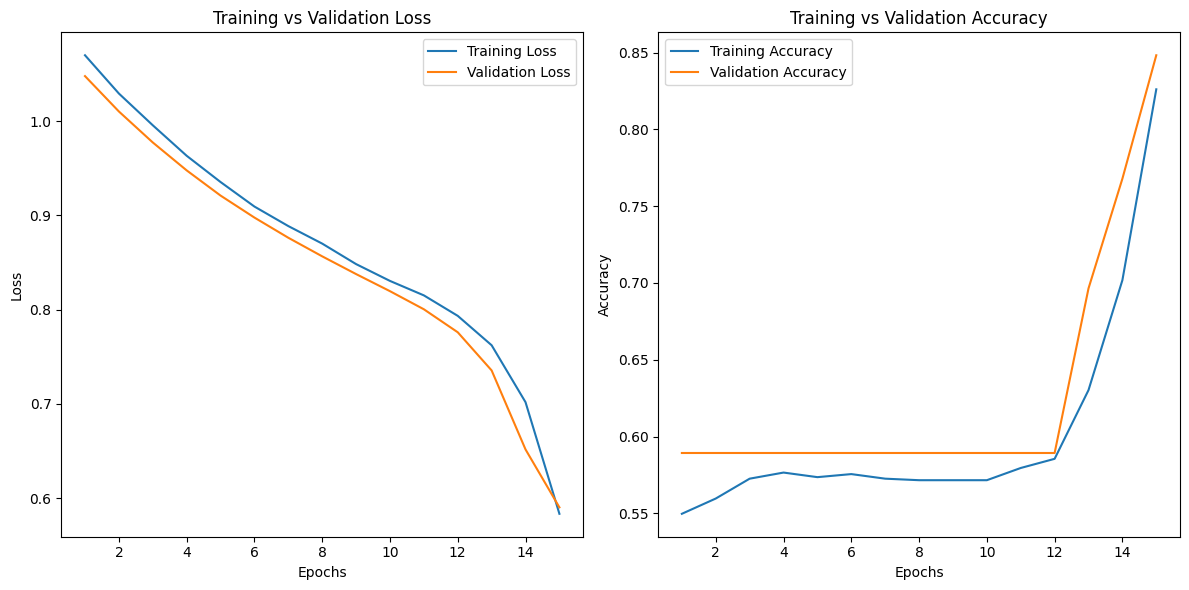

In [ ]:
import matplotlib.pyplot as plt

# Ambil data dari history
history_dict = history.history
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']
train_acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

# Grafik Loss
plt.figure(figsize=(12, 6))

# Subplot untuk loss
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Subplot untuk akurasi
plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_acc) + 1), train_acc, label='Training Accuracy')
plt.plot(range(1, len(val_acc) + 1), val_acc, label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Menampilkan grafik
plt.tight_layout()
plt.show()

In [ ]:
# Akurasi validasi pada epoch terakhir
last_epoch_val_accuracy = history.history['val_accuracy'][-1]

# Akurasi validasi terbaik selama pelatihan
best_val_accuracy = max(history.history['val_accuracy'])

# Menampilkan hasil
print(f"Akurasi pada epoch terakhir: {last_epoch_val_accuracy:.4f}")
print(f"Akurasi terbaik: {best_val_accuracy:.4f}")

Akurasi pada epoch terakhir: 0.7946
Akurasi terbaik: 0.8750


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.87      0.84       142
           1       0.85      0.80      0.83       138

    accuracy                           0.84       280
   macro avg       0.84      0.84      0.84       280
weighted avg       0.84      0.84      0.84       280

Confusion Matrix:
[[123  19]
 [ 27 111]]


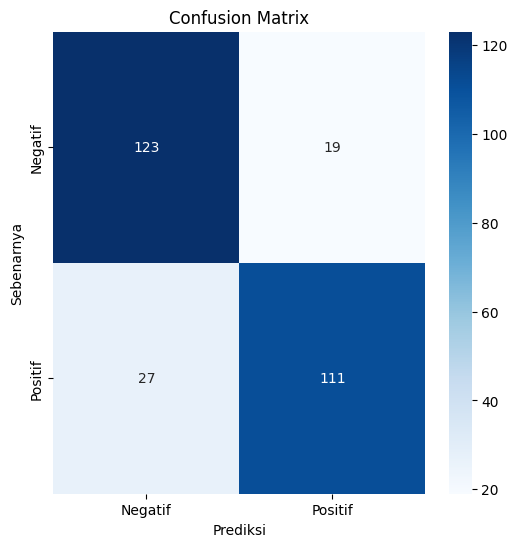

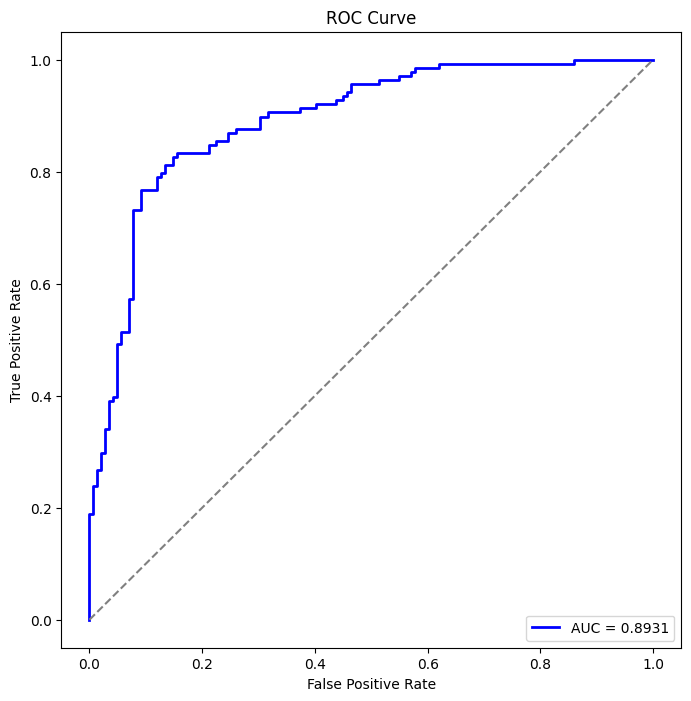

AUC: 0.8931


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# Prediksi probabilitas pada data test
y_pred_probs = model.predict(X_test_pad)

# Konversi prediksi probabilitas ke label 0/1
y_pred = (y_pred_probs > 0.5).astype("int32")

# Menampilkan Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Menampilkan Confusion Matrix
print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Visualisasi Confusion Matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negatif', 'Positif'], yticklabels=['Negatif', 'Positif'])
plt.xlabel('Prediksi')
plt.ylabel('Sebenarnya')
plt.title('Confusion Matrix')
plt.show()

# Menghitung ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)

# Menghitung AUC
roc_auc = auc(fpr, tpr)

# Menampilkan AUC-ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'AUC = {roc_auc:.4f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Menampilkan nilai AUC
print(f'AUC: {roc_auc:.4f}')

Batch 64

In [ ]:
from keras import layers, optimizers, models
from keras.regularizers import l2

EMBEDDING_DIM = 300
GRU_DIM       = 32

sequence_input     = layers.Input(shape=(MAX_SEQUENCE_LENGTH,))
embedded_sequences = layers.Embedding(VOCAB_SIZE, EMBEDDING_DIM, trainable=True)(sequence_input)

# Gunakan L2 Regularization pada GRU
bigru = layers.Bidirectional(
    layers.GRU(GRU_DIM, return_sequences=True, kernel_regularizer=l2(0.001))
)(embedded_sequences)

# Menambahkan Attention Layer (pastikan Anda sudah mendefinisikan AttentionLayer dengan benar)
att = AttentionLayer(MAX_SEQUENCE_LENGTH)(bigru)

# Menambahkan Regularization pada Dense Layer
dense1 = layers.Dense(GRU_DIM*2, activation='relu', kernel_regularizer=l2(0.001))(att)
drop1  = layers.Dropout(0.4)(dense1)

dense2 = layers.Dense(GRU_DIM, activation='relu', kernel_regularizer=l2(0.001))(drop1)
drop2  = layers.Dropout(0.4)(dense2)

outp = layers.Dense(1, activation='sigmoid')(drop2)

model = models.Model(inputs=sequence_input, outputs=outp)
model.compile(
    loss='binary_crossentropy',
    optimizer=optimizers.Adam(learning_rate=0.001),  # Kurangi learning rate
    metrics=['accuracy']
)

from keras.callbacks import EarlyStopping, ModelCheckpoint
import os

# Buat folder untuk menyimpan model terbaik
os.makedirs("best_model", exist_ok=True)

# Setup callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),  # Kurangi patience
    ModelCheckpoint("best_model/best_gru.keras",
                    monitor='val_accuracy',
                    save_best_only=True,
                    mode='max')
]

# Training model — gunakan data yang sudah diproses: X_train_pad, y_train
history = model.fit(
    X_train_pad, y_train,
    batch_size=64,
    epochs=15,
    validation_split=0.1,
    shuffle=True,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 178ms/step - accuracy: 0.5178 - loss: 1.0612 - val_accuracy: 0.5893 - val_loss: 0.9781
Epoch 2/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 208ms/step - accuracy: 0.5591 - loss: 0.9567 - val_accuracy: 0.5893 - val_loss: 0.8927
Epoch 3/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 0.5499 - loss: 0.8833 - val_accuracy: 0.5893 - val_loss: 0.8235
Epoch 4/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 0.5740 - loss: 0.8114 - val_accuracy: 0.5893 - val_loss: 0.7456
Epoch 5/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.6542 - loss: 0.7110 - val_accuracy: 0.8304 - val_loss: 0.6092
Epoch 6/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 0.8197 - loss: 0.5500 - val_accuracy: 0.8214 - val_loss: 0.5426
Epoch 7/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 194ms/step - accuracy: 0.9095 - loss: 0.3746 - val_accuracy: 0.8304 - val_loss: 0.5860
Epoch 8/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 0.9586 - loss: 0.2368 - val_accuracy: 0

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.90      0.83       142
           1       0.88      0.72      0.79       138

    accuracy                           0.81       280
   macro avg       0.82      0.81      0.81       280
weighted avg       0.82      0.81      0.81       280

Confusion Matrix:
[[128  14]
 [ 39  99]]


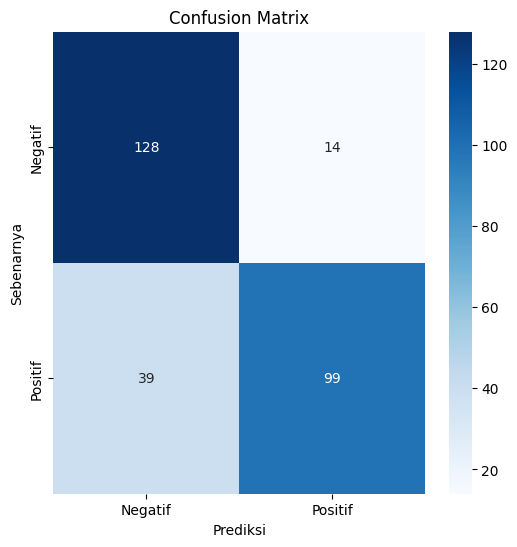

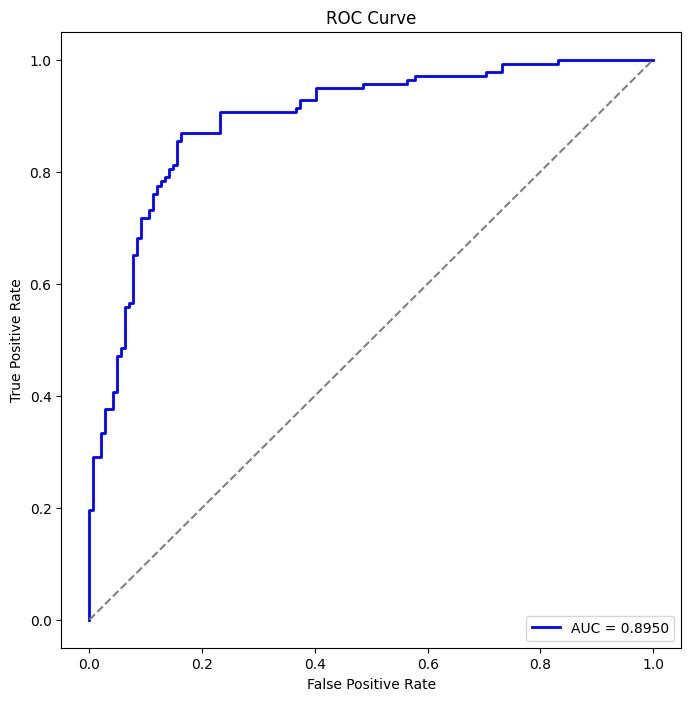

AUC: 0.8950


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# Prediksi probabilitas pada data test
y_pred_probs = model.predict(X_test_pad)

# Konversi prediksi probabilitas ke label 0/1
y_pred = (y_pred_probs > 0.5).astype("int32")

# Menampilkan Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Menampilkan Confusion Matrix
print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Visualisasi Confusion Matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negatif', 'Positif'], yticklabels=['Negatif', 'Positif'])
plt.xlabel('Prediksi')
plt.ylabel('Sebenarnya')
plt.title('Confusion Matrix')
plt.show()

# Menghitung ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)

# Menghitung AUC
roc_auc = auc(fpr, tpr)

# Menampilkan AUC-ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'AUC = {roc_auc:.4f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Menampilkan nilai AUC
print(f'AUC: {roc_auc:.4f}')

## Batch 32

In [ ]:
from keras import layers, optimizers, models
from keras.regularizers import l2

EMBEDDING_DIM = 300
GRU_DIM       = 32

sequence_input     = layers.Input(shape=(MAX_SEQUENCE_LENGTH,))
embedded_sequences = layers.Embedding(VOCAB_SIZE, EMBEDDING_DIM, trainable=True)(sequence_input)

# Gunakan L2 Regularization pada GRU
bigru = layers.Bidirectional(
    layers.GRU(GRU_DIM, return_sequences=True, kernel_regularizer=l2(0.001))
)(embedded_sequences)

# Menambahkan Attention Layer (pastikan Anda sudah mendefinisikan AttentionLayer dengan benar)
att = AttentionLayer(MAX_SEQUENCE_LENGTH)(bigru)

# Menambahkan Regularization pada Dense Layer
dense1 = layers.Dense(GRU_DIM*2, activation='relu', kernel_regularizer=l2(0.001))(att)
drop1  = layers.Dropout(0.4)(dense1)

dense2 = layers.Dense(GRU_DIM, activation='relu', kernel_regularizer=l2(0.001))(drop1)
drop2  = layers.Dropout(0.4)(dense2)

outp = layers.Dense(1, activation='sigmoid')(drop2)

model = models.Model(inputs=sequence_input, outputs=outp)
model.compile(
    loss='binary_crossentropy',
    optimizer=optimizers.Adam(learning_rate=0.0001),  # Kurangi learning rate
    metrics=['accuracy']
)

from keras.callbacks import EarlyStopping, ModelCheckpoint
import os

# Buat folder untuk menyimpan model terbaik
os.makedirs("best_model", exist_ok=True)

# Setup callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),  # Kurangi patience
    ModelCheckpoint("best_model/best_gru.keras",
                    monitor='val_accuracy',
                    save_best_only=True,
                    mode='max')
]

# Training model — gunakan data yang sudah diproses: X_train_pad, y_train
history = model.fit(
    X_train_pad, y_train,
    batch_size=32,
    epochs=15,
    validation_split=0.1,
    shuffle=True,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 103ms/step - accuracy: 0.5399 - loss: 1.0819 - val_accuracy: 0.5893 - val_loss: 1.0637
Epoch 2/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - accuracy: 0.5370 - loss: 1.0603 - val_accuracy: 0.5893 - val_loss: 1.0411
Epoch 3/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - accuracy: 0.5342 - loss: 1.0377 - val_accuracy: 0.5893 - val_loss: 1.0202
Epoch 4/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 87ms/step - accuracy: 0.5824 - loss: 1.0125 - val_accuracy: 0.5893 - val_loss: 1.0006
Epoch 5/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.5570 - loss: 0.9994 - val_accuracy: 0.5893 - val_loss: 0.9824
Epoch 6/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - accuracy: 0.5808 - loss: 0.9772 - val_accuracy: 0.5893 - val_loss: 0.9650
Epoch 7/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - accuracy: 0.5911 - loss: 0.9562 - val_accuracy: 0.5893 - val_loss: 0.9488
Epoch 8/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - accuracy: 0.5737 - loss: 0.9428 - val_accuracy: 0.5893

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# Prediksi probabilitas pada data test
y_pred_probs = model.predict(X_test_pad)

# Konversi prediksi probabilitas ke label 0/1
y_pred = (y_pred_probs > 0.5).astype("int32")

# Menampilkan Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Menampilkan Confusion Matrix
print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Visualisasi Confusion Matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negatif', 'Positif'], yticklabels=['Negatif', 'Positif'])
plt.xlabel('Prediksi')
plt.ylabel('Sebenarnya')
plt.title('Confusion Matrix')
plt.show()

# Menghitung ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)

# Menghitung AUC
roc_auc = auc(fpr, tpr)

# Menampilkan AUC-ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'AUC = {roc_auc:.4f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Menampilkan nilai AUC
print(f'AUC: {roc_auc:.4f}')